In [165]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.style.use('fivethirtyeight')


# DATA

In [166]:
aep = pd.read_csv('/kaggle/input/hourly-energy-consumption/AEP_hourly.csv', index_col=[0], parse_dates=[0])

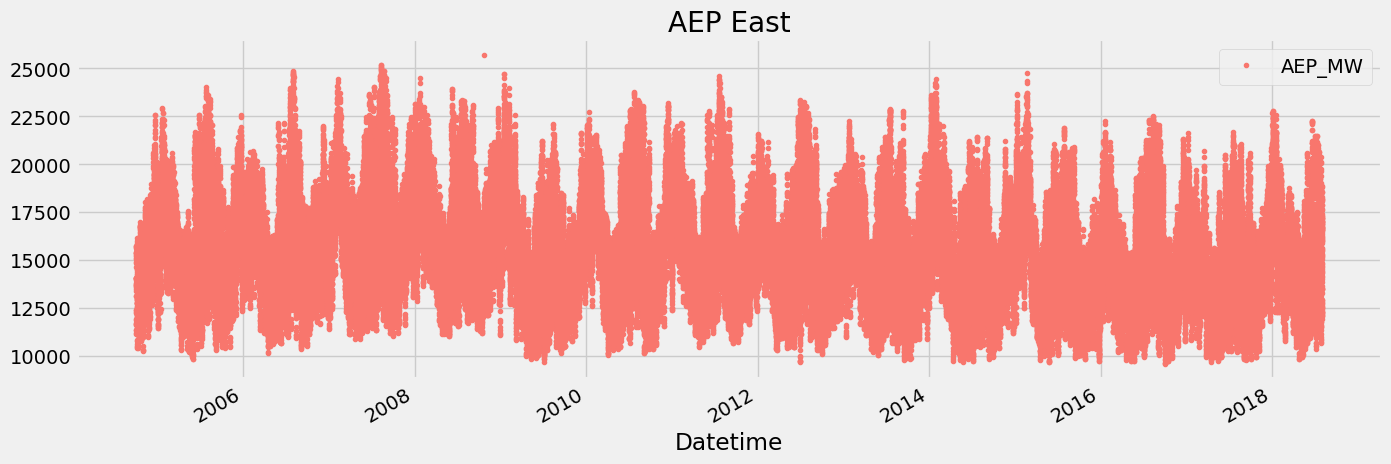

In [167]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = aep.plot(style='.', figsize=(15,5), color=color_pal[0], title='AEP East')

# TRAIN / TEST DATA

In [168]:
split_date = '01-Jan-2014'
aep_train = aep.loc[aep.index <= split_date].copy()
aep_test = aep.loc[aep.index > split_date].copy()

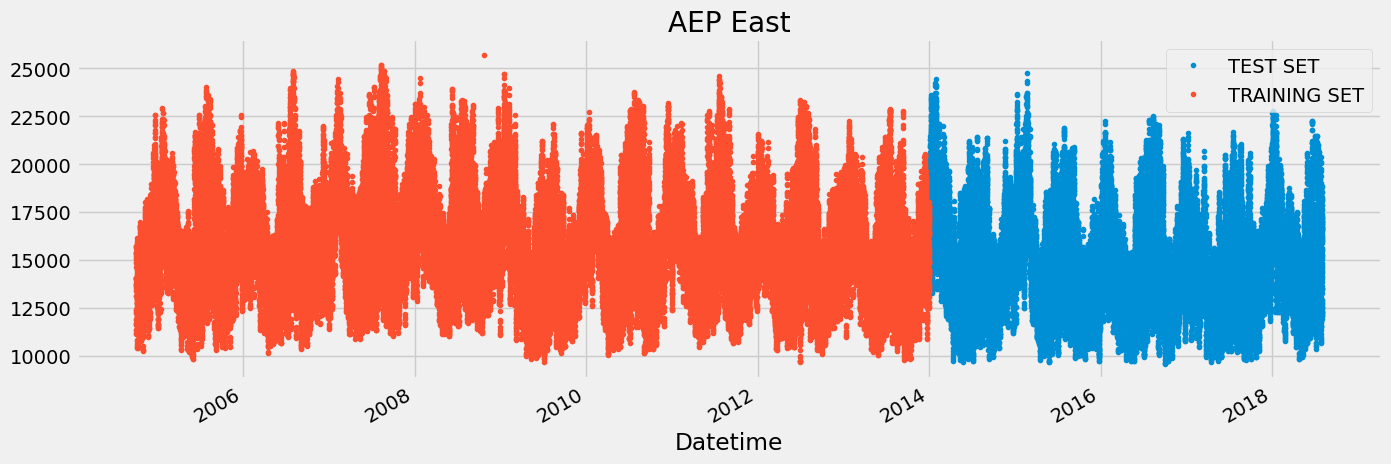

In [169]:
_ = aep_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(aep_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='AEP East', style='.')

# Creating time series feature

In [170]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [171]:
X_train, y_train = create_features(aep_train, label='AEP_MW')
X_test, y_test = create_features(aep_test, label='AEP_MW')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


# Create a XGBoost Model

In [172]:
# reg = xgb.XGBRegressor(n_estimators=2000)
# reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=100, verbose=False) # Change verbose to True if you want to see it train

In [173]:
reg = xgb.XGBRegressor(n_estimators=4000, learning_rate=0.01, max_depth=6, reg_alpha=0.1, reg_lambda=0.1)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100, verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=4000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, reg_lambda=0.1, ...)

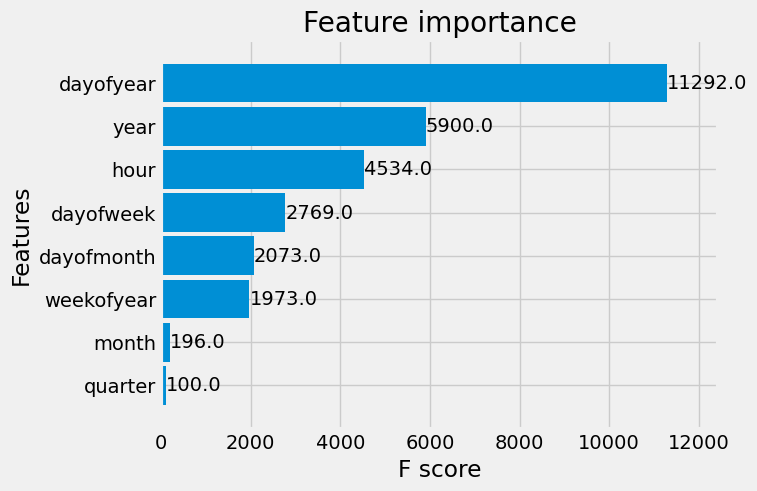

In [174]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test set

In [175]:
aep_test['MW_Prediction'] = reg.predict(X_test)
aep_all = pd.concat([aep_test, aep_train], sort=False)

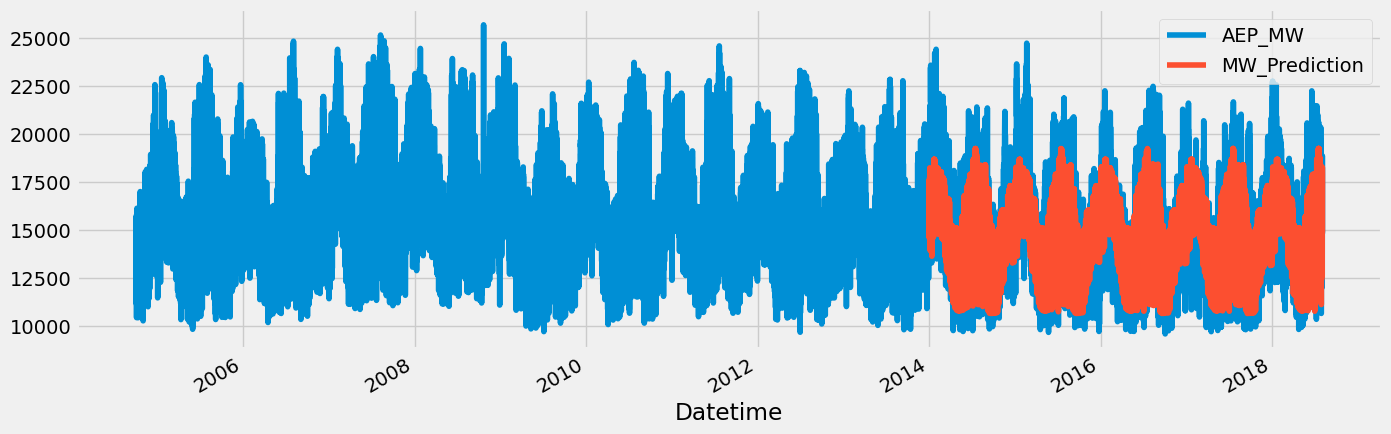

In [176]:
_ = aep_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

# Looking at first month of predictions

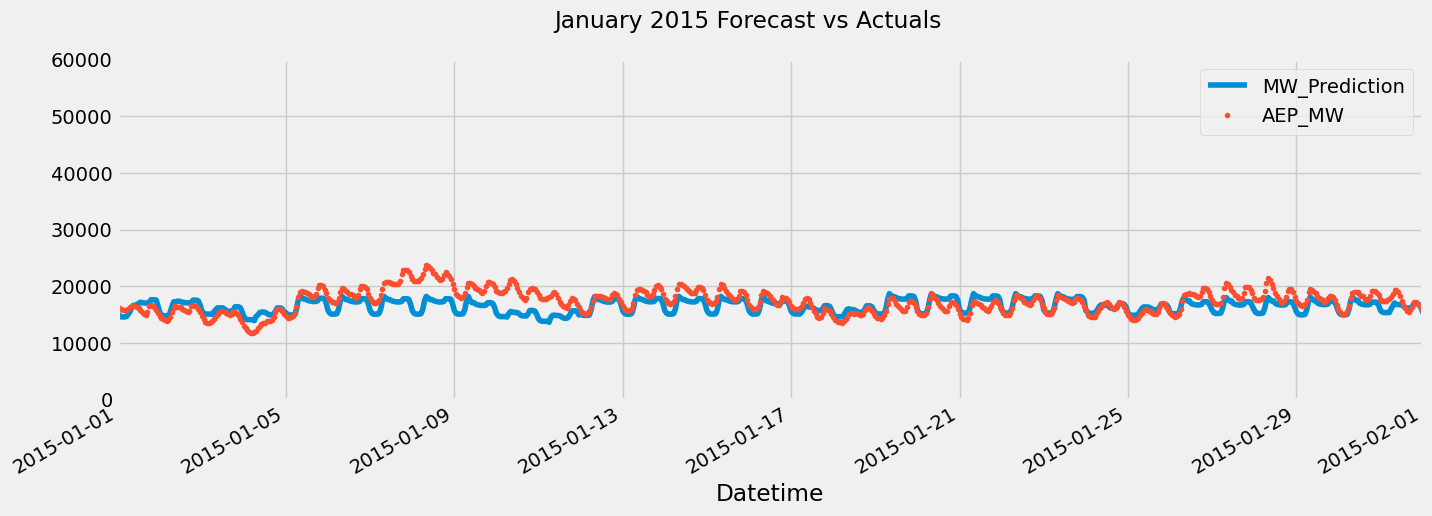

In [177]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = aep_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

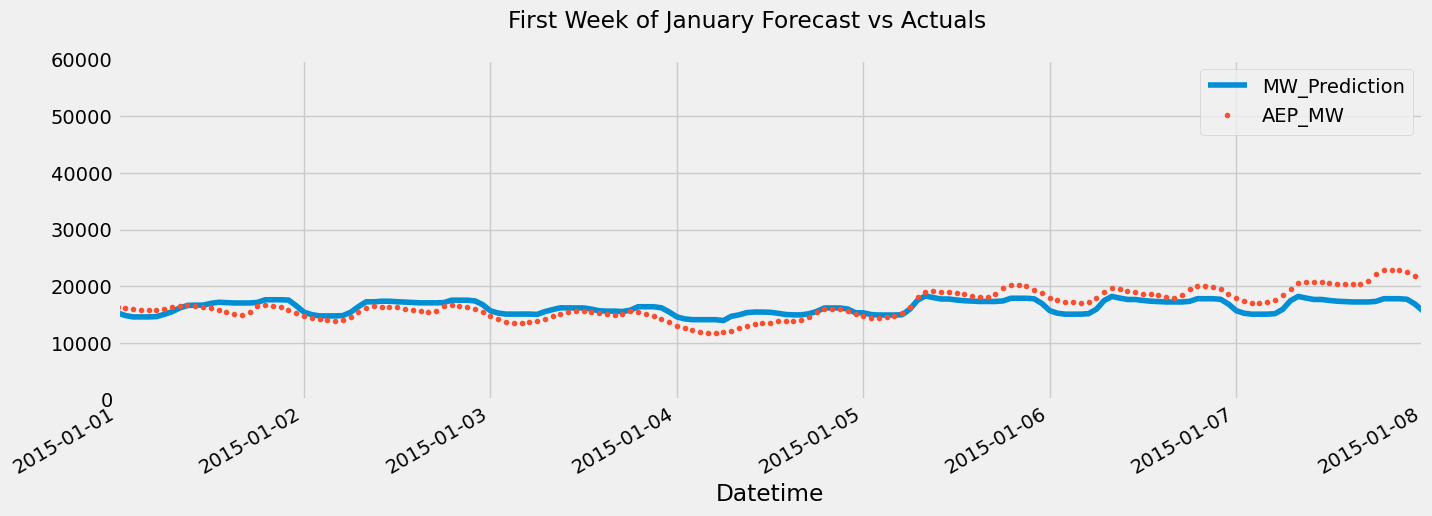

In [178]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = aep_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Error metrics on Test Set

In [179]:
accuracy = r2_score(y_true=aep_test['AEP_MW'], y_pred=aep_test['MW_Prediction']) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 63.54%


In [180]:
mean_squared_error(y_true=aep_test['AEP_MW'], y_pred=aep_test['MW_Prediction'])

2346331.02640571

In [181]:
mean_absolute_error(y_true=aep_test['AEP_MW'], y_pred=aep_test['MW_Prediction'])

1171.4570746387415

In [182]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [183]:
mean_absolute_percentage_error(y_true=aep_test['AEP_MW'], y_pred=aep_test['MW_Prediction'])

7.766093310218182